First, packages are imported.

In [46]:
#   import packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import networkx as nx
import pickle
import functools

from ema_workbench import (
    Model,
    Policy,
    Scenario,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    util,
    ScalarOutcome,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from ema_workbench.em_framework import parameters_from_csv
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import prim
from ema_workbench import Samplers

Load results from Uncertainty Analysis

In [71]:
uncertainty_results_run = pd.read_pickle(r'../generated_datasets/policy_uncertainty_test.pkl')
outcomes_overijssel = pd.read_pickle(r'..\generated_datasets\policy_all_scenarios.pkl')

experiments, results = uncertainty_results_run

### PRIM

PRIM for total cost overijssel:

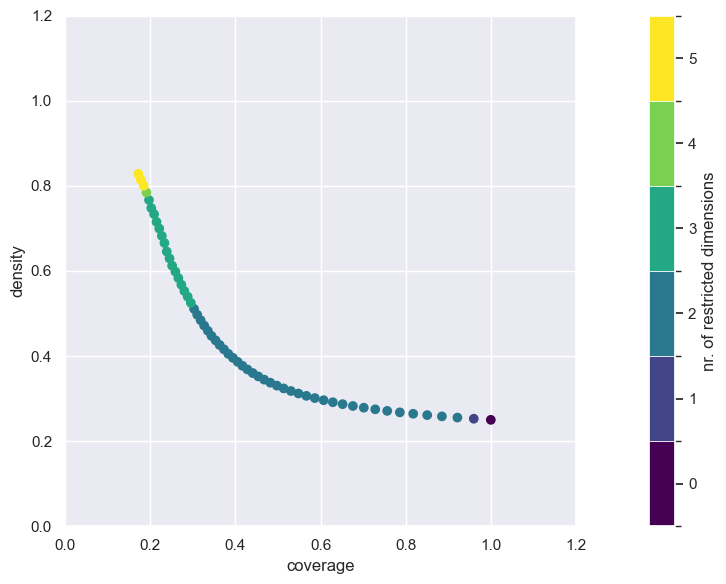

In [81]:
x = experiments.iloc[:, :19]
y = outcomes_overijssel['total_cost[€]_overijssel'].values
y = y > np.percentile(y, 75)

prim_alg = prim.Prim(x,
                     y,
                     threshold=0.75,
                     peel_alpha=0.05, )
box_DC = prim_alg.find_box()

box_DC.show_tradeoff()
plt.tight_layout()

Prim for total cost Gelderland and Overijssel combined:

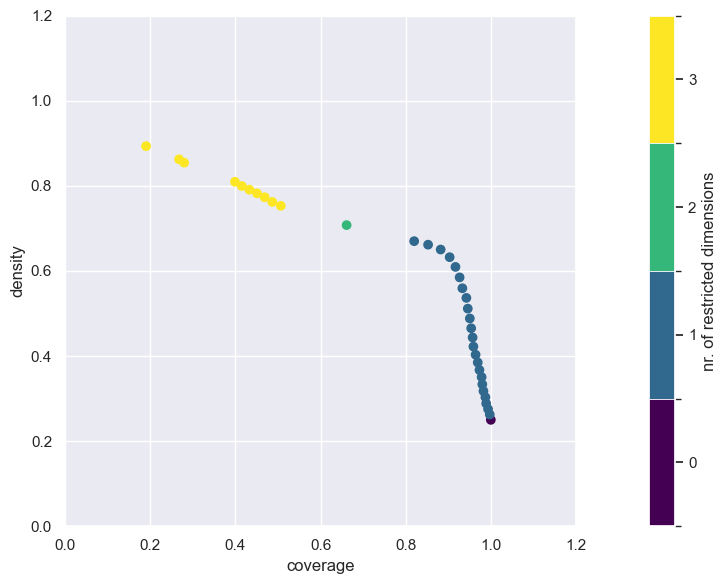

In [82]:
x = experiments.iloc[:, :19]
y = outcomes_overijssel['total_cost[€]'].values
y = y > np.percentile(y, 75)

prim_alg = prim.Prim(x,
                     y,
                     threshold=0.75,
                     peel_alpha=0.05, )
box_DC = prim_alg.find_box()

box_DC.show_tradeoff()
plt.tight_layout()